In [1]:
%matplotlib inline

In [2]:
# Imported libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats import weibull_min, kstest

In [3]:
# Imported python files
from functions import *
from input_variables import *

# IMPROVED OPEN-PIT BENCH BLASTING DESIGN, BASED ON OPTIMIZATION AND MONTE CARLO SIMULATION
# Vol. 3. Monte Carlo simulation and Hypothesis testing

## Overview

Now that we have obtained an optimal solution for the blast deisng parameter, we should evaluate how well it would perform in uncertain conditions, regarding the the rockmass properties. One parameter which is not always robustly estiamted is the Uniaxial compressive strenght (UCS) of the material, as sample gathering and experimental tests are expensive and time-consuming. Nonetheless, certain samples exhist in the geological database of the mining operation for each domain, and therefore it is possible to evaluate the UCS's distribution.

This case study implements the use of the conventional pen and paper solution and the two faster algorithms form *Vol. 2.*

## Distribution fitting for UCS data

Given that we have obtaiend certain measurements on how the UCS differes for a single geological domain, we can use this data to analyze it and model it so that Monte Carlo simulation can be implemented into the optimization problem. here you can see our in-situ data in the following dataframe.

In [4]:
Rock_measurements = pd.read_csv("UCS_data.csv", header = None)
Rock_measurements.columns = ["Rock type", "UCS"]
Rock_measurements

,Rock type,UCS
0,Basalt,197.0
1,Metabasalt,158.0
2,Metabasalt,66.0
3,Metabasalt,146.0
4,Metabasalt,133.0
5,Basalt,95.0
6,Basalt,115.3
7,Basalt,152.4
8,Metabasalt,96.0
9,Metabasalt,111.0


Regardless that different samples are taken from different rock types, they can be part of the same geological domain and therefore can skew the overall UCS value for the rockmass and the Mean fragment size result, as well.
Here is a histogram of the observed UCS values.

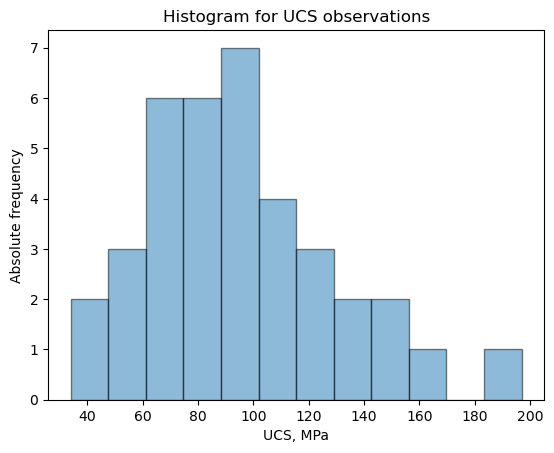

In [5]:
ucs = Rock_measurements.UCS
plt.hist(ucs, bins = 12, alpha = 0.5, edgecolor = "black")
plt.xlabel("UCS, MPa")
plt.ylabel("Absolute frequency")
plt.title("Histogram for UCS observations")

plt.show()

The mean, standard deviation, kurtosis and skewness values are as follows:

In [6]:
ucs.mean()

95.27567567567567

In [7]:
ucs.std()

34.361755269852345

In [8]:
ucs.kurt()

0.9043735205182211

In [9]:
ucs.skew()

0.8005311035546941

The shape of the histogram is assymentrical (positive) and leptokurtic, hence a good initial assumpotion would be to attempt to fit a Weibull distribution to the empirical data. The assumed significance level for the test was assumed to be $\alpha = 0.01$. Hence, the following null and alternative hypotheses were assumed:

$H_{0}$: There is no evidence that the empirical and analytical distributions differ from each other.

$H_{a}$: There is evidence that the empirical and analytical distributions differ from each other.

In [10]:
# Assumed siginificance level for hypothesis rejection
ks_sig_level = 0.01

# Best fit of shape and scale parameters to a Weibull distribution
weibull_params = weibull_min.fit(ucs, floc=0)
weibull_shape = weibull_params[0]
weibull_scale = weibull_params[2]

#Estiamtion of KS statistic and p-value
ks_stat, ks_p_val = kstest(ucs, 'weibull_min', weibull_params)

In [11]:
if ks_p_val >= ks_sig_level:
    print(f"FAIL TO REJECT THE NULL HYPOTHESIS:\nThe empirical distribution does not provide evidence that it differs from a Weibull distribution. (p = {ks_p_val:.3f}, KS stat. = {ks_stat:.3f})")
else:
    print(f"REJECT THE NULL HYPOTHESIS:\nThe empirical distribution provides evidence that it differs from a Weibull distribution. (p = {ks_p_val:.3f}, KS stat. = {ks_stat:.3f})")

FAIL TO REJECT THE NULL HYPOTHESIS:
The empirical distribution does not provide evidence that it differs from a Weibull distribution. (p = 0.789, KS stat. = 0.103)


Results from the Kolmogorov-Smirnov goodness of fit test show, that our initial assumption is reasonable. Below, you can se the empitica

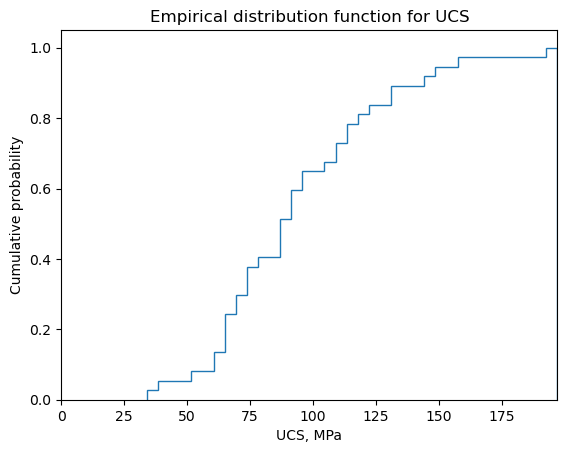

In [12]:
# Plot the cumulative histogram
plt.hist(ucs, bins = 37, density = True, cumulative = True, histtype = 'step', label = 'Empirical CDF')
plt.xlabel('UCS, MPa')
plt.ylabel('Cumulative probability')
plt.title('Empirical distribution function for UCS')
plt.xlim(0, max(ucs))

plt.show()

## Monte Carlo simulation for UCS

Now that we know the shape and scale of the best-fit Weibull distribution, we can do Monte Carlo simulations. First, we need to model the inverse of the Wibull CDF, which is modelled the following way:

In [13]:
def weibull_distribution_inverse(p, f_lambda, f_shape):
    x = f_lambda * (-np.log(1-p))**(1/f_shape)
    return x

Then, we need to vectorize it, so that we can feed an array of the probability values as an argument to the function.

In [14]:
vectorized_weibull_distribution_inverse = np.vectorize(weibull_distribution_inverse)

The transfer function for this case study simulation is for the Cunningham's Rock factor ($A$):

$ A = 0.06 \cdot (JF + RMD + RDI + HF)$

where $JF$ is the joint factor

$RMD$ is the rock mass designation

$RDI$ is the rock density influence

$HF$ is the hardness factor

Each of the following parameters is calculated via the following formulae:

$JF = JPO + JPS$

$RMD = 
\begin{cases}
    10, & \text{Powdery/friable rock}  \\
    JF,  & \text{Vertically jointed} \\
    50,  & \text{Massive}  
\end{cases}$

$RDI = 25 \cdot \rho_{r} - 50$

$HF = 
\begin{cases}
    E/3, & \text{if } E < 50 GPa \\
    UCS/5,  & \text{if } E > 50 GPa
\end{cases}$

This case study assumes that the Young's module ($E$) is over 50 GPa and hence, the UCS value is used for the calculation of the Hardness factor. Therefore, by simulating different values for the UCS, we can also simulate the distribution of the Rock factor and hence take into account the uncertainty behin its true value for the blast panel.

The `sim_rock_factor` function does exactly this bu implementing the simulated distribtuion of the UCS value and incorporating it in the following formulae.

In [15]:
def sim_rock_factor(p, scale, shape, rm_density, rm_jpo, rm_jps, rm_rdi = 0):
    '''Transfer function for Rock factor simulation'''
    
    rock_mass_designation = 25 * rm_density - 50
    joint_factor = rm_jpo + rm_jps
    rock_density_influence = joint_factor
    ucs_array= vectorized_weibull_distribution_inverse(p, scale, shape)
    hardness_factor_array = ucs_array / 5
    rock_factor_array = 0.06*(rock_mass_designation + joint_factor + rock_density_influence + hardness_factor_array)
    
    return rock_factor_array

Basically, the function is drawing balls from a hat with replacement and for each uniformly distributed value in the interval $[0, 1]$ it is applied to the inverse function of the Weibull distribution to obtain the respective UCS value.

In [16]:
rm_jpo = 30
rm_jps = 20

In [17]:
def plot_kuz_ram_results(x50, uniformity_idx):
    ''' Plots the CDF of the rock fragments for the Kuz-Ram model 
    Чертае кумулативната плътност на разпределението на скалните късове по модела Kuz-Ram '''

    x = np.linspace(0, 2000, 10)

    kuz_ram_model_vectorized = np.vectorize(kuz_ram_model)
    y = kuz_ram_model_vectorized(uniformity_idx, x50, x)
    
    plt.plot(x, 100 * y, color = "tab:blue", linewidth = 0.125)
    plt.xlabel("Rock fragment size, mm")
    plt.ylabel("Passing, %")
    plt.yticks(range(0, 101, 10))
    plt.xlim(0, 2000)
    plt.ylim(0, 101)

Now that we can imitate the UCS uncertainty in the rock mass, let's see how the different solutions from the previous botebook behave in different conditions.

## Comparsion

In order to compare how well different solutions work in these uncertain conditions, the design features from the conventional way of calculation have been used for comparison. In addition, two of the optimal solutions were also used for the comparison, including the solution from the Search with an accelerated step size (SASS) method and the Random search method (RS). Once omre, the assumed siginficance level is $\alpha = 0.01$.

In [18]:
significance_level = 0.01

Here the user can input the parameters for different design alternatvies, which one wants to compare by the t-test. The input provided for this example includes the Conventional solution, the RS solution and the SASS solution.

In [19]:
# Conventional solution - blast design
burden_conv = 5.57
spacing_conv = 5.57
subdrilling_conv = 1.67
stemming_conv = 5.57

# Conventional solution - charging rules
bp_dh_exp_mass_conv = calc_bp_dh_charge(burden_conv, spacing_conv, bp_height,
                                        subdrilling_conv, stemming_conv, bp_dh_diameter, expl_density)["DH charge mass, kg"]
bp_dh_spec_charge_conv = calc_bp_dh_charge(burden_conv, spacing_conv, bp_height,
                                        subdrilling_conv, stemming_conv, bp_dh_diameter, expl_density)["DH spec. charge, kg/m³"]
bp_dh_exp_length_conv = calc_bp_dh_charge(burden_conv, spacing_conv, bp_height,
                                        subdrilling_conv, stemming_conv, bp_dh_diameter, expl_density)["DH charge length, m"]

# Conventional solution - UCS simulation
p_rand_conv = np.random.rand(1000)
rock_factor_conv = sim_rock_factor(p_rand_conv, weibull_scale, weibull_shape, rm_density, rm_jpo, rm_jps)

In [20]:
# Random search solution - blast design
burden_RS = 4.52
spacing_RS = 5.89
subdrilling_RS = 1.53
stemming_RS = 6.86

# Random search solution - charging rules
bp_dh_exp_mass_RS = calc_bp_dh_charge(burden_RS, spacing_RS, bp_height,
                                       subdrilling_RS, stemming_RS, bp_dh_diameter, expl_density)["DH charge mass, kg"]
bp_dh_spec_charge_RS = calc_bp_dh_charge(burden_RS, spacing_RS, bp_height,
                                          subdrilling_RS, stemming_RS, bp_dh_diameter, expl_density)["DH spec. charge, kg/m³"]
bp_dh_exp_length_RS = calc_bp_dh_charge(burden_RS, spacing_RS, bp_height,
                                         subdrilling_RS, stemming_RS, bp_dh_diameter, expl_density)["DH charge length, m"]

# Random search solution - UCS simulation
p_rand_RS = np.random.rand(1000)
rock_factor_RS = sim_rock_factor(p_rand_RS, weibull_scale, weibull_shape, rm_density, rm_jpo, rm_jps)

In [21]:
# SASS solution - blast design
burden_SASS = 4.51
spacing_SASS = 5.89
subdrilling_SASS = 1.0
stemming_SASS = 6.46

# SASS solution - charging rules
bp_dh_exp_mass_SASS = calc_bp_dh_charge(burden_SASS, spacing_SASS, bp_height,
                                       subdrilling_SASS, stemming_SASS, bp_dh_diameter, expl_density)["DH charge mass, kg"]
bp_dh_spec_charge_SASS = calc_bp_dh_charge(burden_SASS, spacing_SASS, bp_height,
                                          subdrilling_SASS, stemming_SASS, bp_dh_diameter, expl_density)["DH spec. charge, kg/m³"]
bp_dh_exp_length_SASS = calc_bp_dh_charge(burden_SASS, spacing_SASS, bp_height,
                                         subdrilling_SASS, stemming_SASS, bp_dh_diameter, expl_density)["DH charge length, m"]

# SASS solution - UCS simulation
p_rand_SASS = np.random.rand(1000)
rock_factor_SASS = sim_rock_factor(p_rand_SASS, weibull_scale, weibull_shape, rm_density, rm_jpo, rm_jps)

The base hypothesis for each comparison is when comparing different design alternatives according to a certain criteria are as follows:

$H_{0}$: There is no evidence that the both solutions differ from each other in terms of the compared criteria.

$H_{a}$: There is evidence that the both solutions differ from each other in terms of the compared criteria.

### Mean fragment size (X50) comparison

In [22]:
vectorized_calc_x50 = np.vectorize(calc_x50)

In [23]:
x50_array_conv = vectorized_calc_x50(bp_dh_exp_mass_conv, bp_dh_spec_charge_conv, rock_factor_conv, expl_rws)
x50_array_SASS = vectorized_calc_x50(bp_dh_exp_mass_SASS, bp_dh_spec_charge_SASS, rock_factor_SASS, expl_rws)
x50_array_RS = vectorized_calc_x50(bp_dh_exp_mass_RS, bp_dh_spec_charge_RS, rock_factor_RS, expl_rws)

x50_array_conv_mean = np.mean(x50_array_conv)
x50_array_SASS_mean = np.mean(x50_array_SASS)
x50_array_RS_mean = np.mean(x50_array_RS)

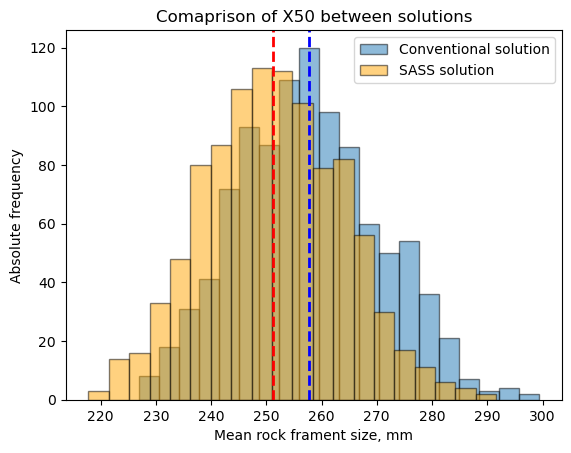

In [24]:
plt.axvline(x50_array_conv_mean, color = 'blue', linestyle = 'dashed', linewidth = 2)
plt.axvline(x50_array_SASS_mean, color = 'red', linestyle = 'dashed', linewidth = 2)

plt.hist(x50_array_conv, bins = 20, color = "tab:blue", alpha = 0.5, edgecolor = "black", label = "Conventional solution")
plt.hist(x50_array_SASS, bins = 20, color = "orange", alpha = 0.5, edgecolor = "black", label = "SASS solution")

plt.xlabel("Mean rock frament size, mm")
plt.ylabel("Absolute frequency")
plt.legend()
plt.title("Comaprison of X50 between solutions")

plt.show()

In [25]:
t_stat_x50, p_val_x50 = stats.ttest_ind(x50_array_conv, x50_array_SASS)
if p_val_x50 >= significance_level:
    print(f"In terms of the Mean fragment size, there is no evidence that \
the SASS solution would yield better fragmentation results, compared to the Conventional solution.")
else:
    print(f"In terms of the Mean fragment size, there is evidence that the SASS solution would yield \
better fragmentation results, compared to the Conventional solution (p = {p_val_x50:.3f}, t = {t_stat_x50:.3f})")

In terms of the Mean fragment size, there is evidence that the SASS solution would yield better fragmentation results, compared to the Conventional solution (p = 0.000, t = 11.454)


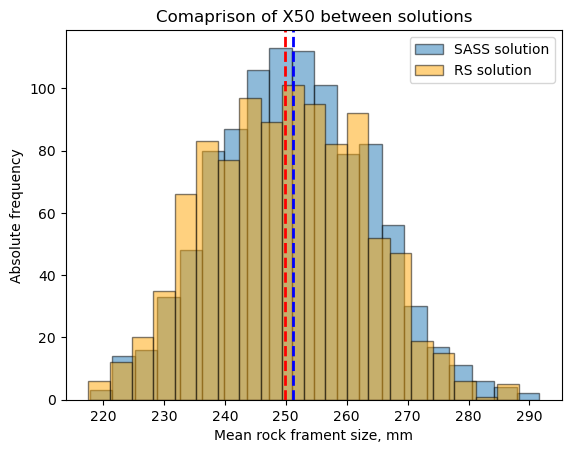

In [26]:
plt.axvline(x50_array_SASS_mean, color = 'blue', linestyle = 'dashed', linewidth = 2)
plt.axvline(x50_array_RS_mean, color = 'red', linestyle = 'dashed', linewidth = 2)

plt.hist(x50_array_SASS, bins = 20, color = "tab:blue", alpha = 0.5, edgecolor = "black", label = "SASS solution")
plt.hist(x50_array_RS, bins = 20, color = "orange", alpha = 0.5, edgecolor = "black", label = "RS solution")

plt.xlabel("Mean rock frament size, mm")
plt.ylabel("Absolute frequency")
plt.legend()
plt.title("Comaprison of X50 between solutions")

plt.show()

In [27]:
t_stat_x50, p_val_x50 = stats.ttest_ind(x50_array_SASS, x50_array_RS)
if p_val_x50 >= significance_level:
    print(f"FAIL TO REJECT THE NULL HYPOTHESIS:\nIn terms of the Mean fragment size, there is no evidence that \
the SASS solution would yield better fragmentation results, compared to the RS solution.")
else:
    print(f"REJECT THE NULL HYPOTHESIS:\nIn terms of the Mean fragment size, there is evidence that the SASS solution would yield \
better fragmentation results, compared to the RS solution (p = {p_val_x50:.3f}, t = {t_stat_x50:.3f})")

FAIL TO REJECT THE NULL HYPOTHESIS:
In terms of the Mean fragment size, there is no evidence that the SASS solution would yield better fragmentation results, compared to the RS solution.


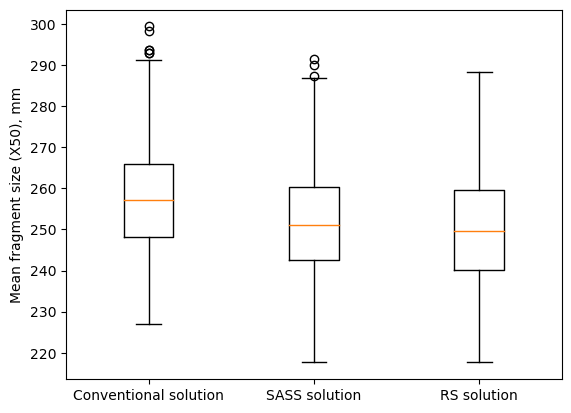

In [28]:
plt.boxplot([x50_array_conv, x50_array_SASS, x50_array_RS], 
            labels = ["Conventional solution", "SASS solution", "RS solution"])
plt.ylabel("Mean fragment size (X50), mm")

plt.show()

The SASS and RS solutions are very similar, however, they differ significantly from the Conventional one.

### Oversize percentage comparison

In [29]:
vectorized_uniformity_idx_mod = np.vectorize(calc_uniformity_idx_mod)
vectorized_kuz_ram_model = np.vectorize(kuz_ram_model)

In [30]:
n_conv = vectorized_uniformity_idx_mod(burden_conv, spacing_conv, bp_dh_diameter, 
                                       bp_dh_exp_length_conv, bp_dh_dev, bp_height, rock_factor_conv)

n_SASS = vectorized_uniformity_idx_mod(burden_SASS, spacing_SASS, bp_dh_diameter, 
                                       bp_dh_exp_length_SASS, bp_dh_dev, bp_height, rock_factor_SASS)

n_RS = vectorized_uniformity_idx_mod(burden_RS, spacing_RS, bp_dh_diameter, 
                                       bp_dh_exp_length_RS, bp_dh_dev, bp_height, rock_factor_RS)

In [31]:
oversize_array_conv = 100 - vectorized_kuz_ram_model(n_conv, x50_array_conv, 1000)
oversize_array_SASS = 100 - vectorized_kuz_ram_model(n_SASS, x50_array_SASS, 1000)
oversize_array_RS = 100 - vectorized_kuz_ram_model(n_RS, x50_array_RS, 1000)

oversize_array_conv_mean = np.mean(oversize_array_conv)
oversize_array_SASS_mean = np.mean(oversize_array_SASS)
oversize_array_RS_mean = np.mean(oversize_array_RS)

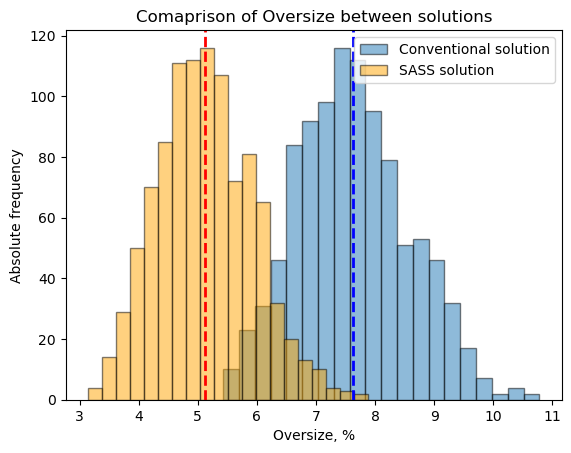

In [32]:
plt.axvline(oversize_array_conv_mean, color = 'blue', linestyle = 'dashed', linewidth = 2)
plt.axvline(oversize_array_SASS_mean, color = 'red', linestyle = 'dashed', linewidth = 2)

plt.hist(oversize_array_conv, bins = 20, color = "tab:blue", alpha = 0.5, edgecolor = "black", label = "Conventional solution")
plt.hist(oversize_array_SASS, bins = 20, color = "orange", alpha = 0.5, edgecolor = "black", label = "SASS solution")

plt.xlabel("Oversize, %")
plt.ylabel("Absolute frequency")
plt.legend()
plt.title("Comaprison of Oversize between solutions")

plt.show()

In [33]:
t_stat_oversize, p_val_oversize = stats.ttest_ind(oversize_array_conv, oversize_array_SASS)
if p_val_oversize >= significance_level:
    print(f"FAIL TO REJECT THE NULL HYPOTHESIS:\nIn terms of Oversize, there is no evidence that the SASS solution would yield better fragmentation results, \
compared to the Conventional solution.")
else:
    print(f"REJECT THE NULL HYPOTHESIS:\nIn terms of Oversize, there is evidence that the SASS solution would yield better fragmentation results, \
compared to the Conventional solution (p = {p_val_oversize:.3f}, t = {t_stat_oversize:.3f})")

REJECT THE NULL HYPOTHESIS:
In terms of Oversize, there is evidence that the SASS solution would yield better fragmentation results, compared to the Conventional solution (p = 0.000, t = 63.568)


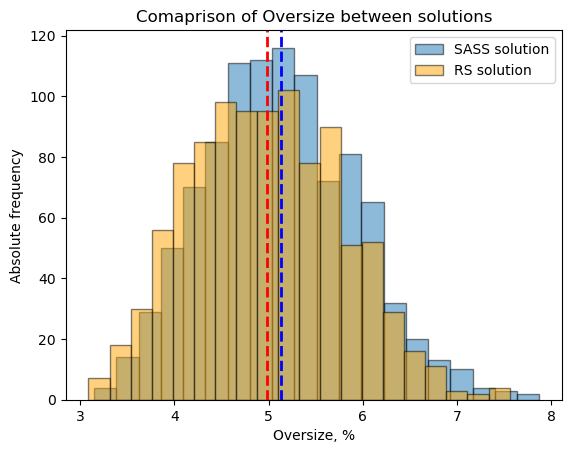

In [34]:
plt.axvline(oversize_array_SASS_mean, color = 'blue', linestyle = 'dashed', linewidth = 2)
plt.axvline(oversize_array_RS_mean, color = 'red', linestyle = 'dashed', linewidth = 2)

plt.hist(oversize_array_SASS, bins = 20, color = "tab:blue", alpha = 0.5, edgecolor = "black", label = "SASS solution")
plt.hist(oversize_array_RS, bins = 20, color = "orange", alpha = 0.5, edgecolor = "black", label = "RS solution")

plt.xlabel("Oversize, %")
plt.ylabel("Absolute frequency")
plt.legend()
plt.title("Comaprison of Oversize between solutions")

plt.show()

In [35]:
t_stat_oversize, p_val_oversize = stats.ttest_ind(oversize_array_SASS, oversize_array_RS)
if p_val_oversize >= significance_level:
    print(f"FAIL TO REJECT THE NULL HYPOTHESIS:\nIn terms of Oversize, there is no evidence that the SASS solution would yield better fragmentation results, \
compared to the RS solution. (p = {p_val_oversize:.3f}, t = {t_stat_oversize:.3f})")
else:
    print(f"REJECT THE NULL HYPOTHESIS:\nIn terms of Oversize, there is evidence that the SASS solution would yield better fragmentation results, \
compared to the RS solution (p = {p_val_oversize:.3f}, t = {t_stat_oversize:.3f})")

REJECT THE NULL HYPOTHESIS:
In terms of Oversize, there is evidence that the SASS solution would yield better fragmentation results, compared to the RS solution (p = 0.000, t = 4.174)


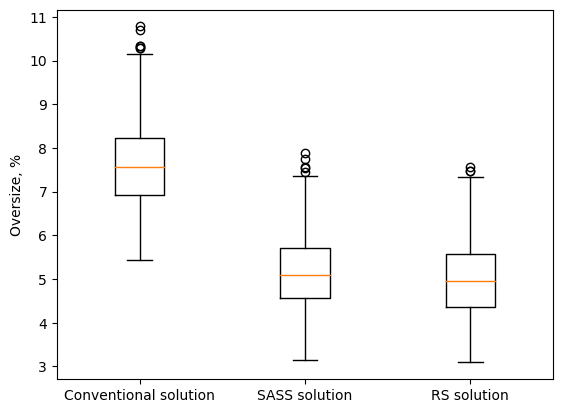

In [36]:
plt.boxplot([oversize_array_conv, oversize_array_SASS, oversize_array_RS], 
            labels = ["Conventional solution", "SASS solution", "RS solution"])
plt.ylabel("Oversize, %")

plt.show()

Once more, the SASS and RS solutions are very similar, however, they differ significantly from the Conventional one.

In [37]:
oversize_df = pd.DataFrame(oversize_array_conv, columns = ["Conventional model"])

### Total costs comparison

In [38]:
def mining_ops(bp_burden, bp_spacing, bp_dh_subdrilling, bp_dh_stemming, rm_rock_factor):
    '''Caluclates total mining costs, based on blast deisng parameters and global variables for mining equipment, prices, 
    rockmass properties and blast panel features '''
    
    charge =  calc_bp_dh_charge(bp_burden, bp_spacing, bp_height, 
                                bp_dh_subdrilling, bp_dh_stemming, bp_dh_diameter, expl_density)
    bp_dh_length = charge["DH length, m"]
    bp_dh_exp_length = charge["DH charge length, m"]
    bp_dh_exp_mass = charge["DH charge mass, kg"]
    bp_dh_spec_charge = charge["DH spec. charge, kg/m³"]
    
    bp_total = calc_bp_total(bp_height, bp_width, bp_length, bp_slope_angle, 
                             bp_burden, bp_spacing, bp_dh_length, bp_dh_exp_mass)
    bp_dh_rows_cnt = bp_total["Rows"]
    bp_dh_per_row_cnt = bp_total["DHs per row"]
    bp_total_dh_cnt = bp_total["Total DH count"]
    bp_total_dh_length = bp_total["Total DH length, m"]
    bp_total_volume = bp_total["Total rock volume, m³"]
    bp_total_exp_mass = bp_total["Total explosive mass, kg"]
    
    frag_uniformity_idx_mod = calc_uniformity_idx_mod(bp_burden, bp_spacing, 
                                                      bp_dh_diameter, bp_dh_exp_length, bp_dh_dev, bp_height, rm_rock_factor)
    
    frag_x50 = calc_x50(bp_dh_exp_mass, bp_dh_spec_charge, rm_rock_factor, expl_rws)
    
    frag_oversize = 100 - 100 * kuz_ram_model(frag_uniformity_idx_mod, frag_x50, 1000)
    
    loader_fill_factor = set_fill_factor(frag_x50)
    loader_h_prod = 3600 / loader_s_cycle * loader_fill_factor * loader_bucket_vol / rm_swell_factor

    truck_tr_t = calc_truck_tr_t(loader_bucket_vol, rm_density, rm_swell_factor, loader_fill_factor, truck_cap_t)
    truck_h_prod =  truck_tr_t * (60 / truck_min_haul)
    
    costs_drilling = calc_drilling(bp_total_dh_length, drill_h_rate, drill_h_costs)["Costs"]
    costs_blasting = calc_blasting(bp_total_exp_mass, expl_price)["Costs"]
    costs_loading = calc_loading(bp_total_volume, loader_h_prod, loader_h_costs)["Costs"]
    costs_hauling = calc_hauling(bp_total_volume, truck_h_prod, truck_h_costs, rm_density)["Costs"]
    costs_total = costs_drilling + costs_blasting + costs_loading + costs_hauling
    
    result_dict = {"Burden, m": bp_burden,
                   "Spacing, m": bp_spacing,
                   "Stemming, m": bp_dh_stemming,
                   "Subdrilling, m": bp_dh_subdrilling,
                   "DH length, m": bp_dh_length,
                   "DH expl. mass, kg": bp_dh_exp_mass,
                   "DH spec. charge, kg/m³": bp_dh_spec_charge,
                   "Rows": bp_dh_rows_cnt,
                   "Holes per row": bp_dh_per_row_cnt,
                   "Total number of drillholes": bp_total_dh_cnt,
                   "Total drillhole length, m": bp_total_dh_length,
                   "Total explosive mass, kg": bp_total_exp_mass,
                   "Drilling costs, kEUR": costs_drilling,
                   "Blasting costs, kEUR": costs_blasting, 
                   "Loading costs, kEUR": costs_loading, 
                   "Haul costs, kEUR": costs_hauling, 
                   "Total costs, kEUR": costs_total, 
                   "X50, mm": frag_x50, 
                   "Uniformity index": frag_uniformity_idx_mod, 
                   "Oversize, %": frag_oversize}
    
    return result_dict

In [39]:
vectorized_mining_ops = np.vectorize(mining_ops)

In [40]:
Z_conv = vectorized_mining_ops(burden_conv, spacing_conv, subdrilling_conv, stemming_conv, rock_factor_conv)
Z_SASS = vectorized_mining_ops(burden_SASS, spacing_SASS, subdrilling_SASS, stemming_SASS, rock_factor_SASS)
Z_RS = vectorized_mining_ops(burden_RS, spacing_RS, subdrilling_RS, stemming_RS, rock_factor_RS)

total_costs_conv = [d["Total costs, kEUR"] for d in Z_conv]
total_costs_SASS = [d["Total costs, kEUR"] for d in Z_SASS]
total_costs_RS = [d["Total costs, kEUR"] for d in Z_RS]

total_costs_conv_mean = np.mean(total_costs_conv)
total_costs_SASS_mean = np.mean(total_costs_SASS)
total_costs_RS_mean = np.mean(total_costs_RS)

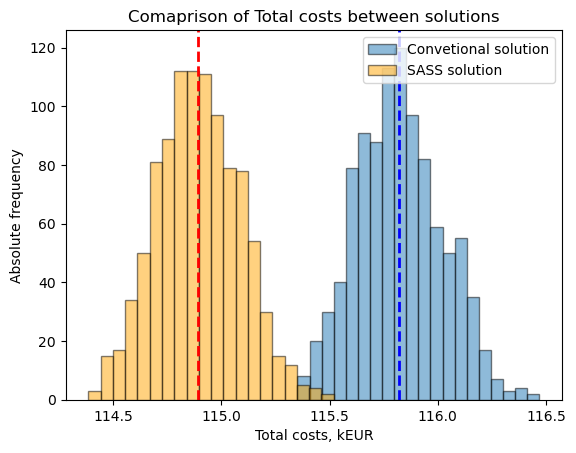

In [41]:
plt.axvline(total_costs_conv_mean, color = 'blue', linestyle = 'dashed', linewidth = 2)
plt.axvline(total_costs_SASS_mean, color = 'red', linestyle = 'dashed', linewidth = 2)

plt.hist(total_costs_conv, bins = 20, color = "tab:blue", alpha = 0.5, edgecolor = "black", label = "Convetional solution")
plt.hist(total_costs_SASS, bins = 20, color = "orange", alpha = 0.5, edgecolor = "black", label = "SASS solution")

plt.xlabel("Total costs, kEUR")
plt.ylabel("Absolute frequency")
plt.legend()
plt.title("Comaprison of Total costs between solutions")

plt.show()

In [42]:
t_stat_costs, p_val_costs = stats.ttest_ind(total_costs_conv, total_costs_SASS)
if p_val_costs >= significance_level:
    print(f"FAIL TO REJECT THE NULL HYPOTHESIS:\nIn terms of Total costs, there is no evidence that the SASS solution would be more economically feasible, \
compared to the Conventional solution. (p = {p_val_costs:.3f}, t = {t_stat_costs:.3f})")
else:
    print(f"REJECT THE NULL HYPOTHESIS:\nIn terms of Total costs, there is statisically significant evidence that the SASS solution would \
be more economically feasible, compared to the Conventional solution (p = {p_val_costs:.3f}, t = {t_stat_costs:.3f}).")

REJECT THE NULL HYPOTHESIS:
In terms of Total costs, there is statisically significant evidence that the SASS solution would be more economically feasible, compared to the Conventional solution (p = 0.000, t = 106.256).


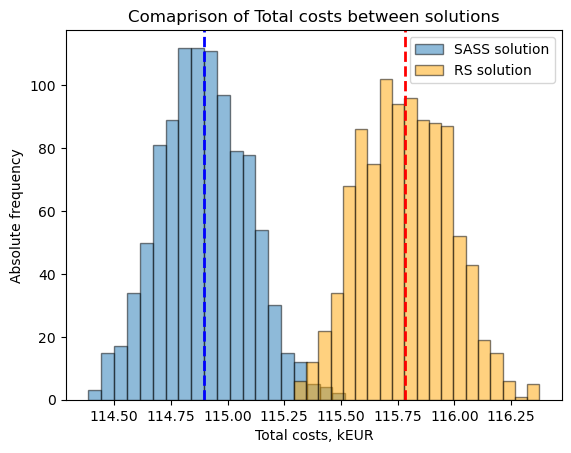

In [43]:
plt.axvline(total_costs_SASS_mean, color = 'blue', linestyle = 'dashed', linewidth = 2)
plt.axvline(total_costs_RS_mean, color = 'red', linestyle = 'dashed', linewidth = 2)

plt.hist(total_costs_SASS, bins = 20, color = "tab:blue", alpha = 0.5, edgecolor = "black", label = "SASS solution")
plt.hist(total_costs_RS, bins = 20, color = "orange", alpha = 0.5, edgecolor = "black", label = "RS solution")

plt.xlabel("Total costs, kEUR")
plt.ylabel("Absolute frequency")
plt.legend()
plt.title("Comaprison of Total costs between solutions")

plt.show()

In [44]:
t_stat_costs, p_val_costs = stats.ttest_ind(total_costs_conv, total_costs_SASS)
if p_val_costs >= significance_level:
    print(f"FAIL TO REJECT THE NULL HYPOTHESIS:\nIn terms of Total costs, there is no evidence that the SASS solution would be more economically feasible, \
compared to the RS solution. (p = {p_val_costs:.3f}, t = {t_stat_costs:.3f})")
else:
    print(f"REJECT THE NULL HYPOTHESIS:\nIn terms of Total costs, there is statisically significant evidence that the SASS solution would \
be more economically feasible, compared to the RS solution (p = {p_val_costs:.3f}, t = {t_stat_costs:.3f}).")

REJECT THE NULL HYPOTHESIS:
In terms of Total costs, there is statisically significant evidence that the SASS solution would be more economically feasible, compared to the RS solution (p = 0.000, t = 106.256).


The next figure shows a Box plot diagram which provides a good way of showing how different can the resutls be, regarding the three compared solutions.

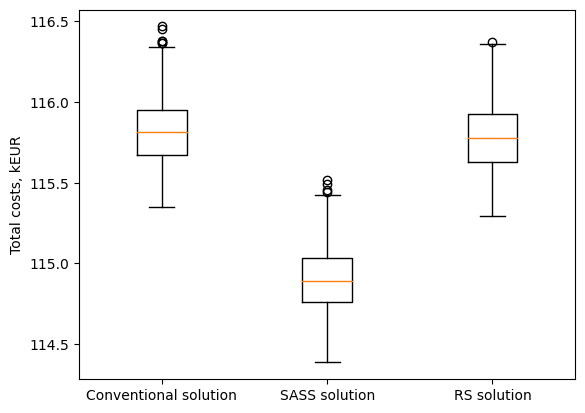

In [45]:
plt.boxplot([total_costs_conv, total_costs_SASS, total_costs_RS], 
            labels = ["Conventional solution", "SASS solution", "RS solution"])
plt.ylabel("Total costs, kEUR")

plt.show()

All solutions differ from one another and still the SASS solution is the most optimal one, regardles of the fluctiation in the Total costs.

## Conclusion

This approach provides a step forward from the conventional otpimziation approach and hence for future research the objective function may need to be redefined in order to account for the probability of blasting scenarios exceeding the defiend Oversize threshold. Nonetheles,, this compelx approach provides a good understanding how different solution from optimization algorithms can behave in different ways, given thatuncertainty is added into the model.
hence, solutions from reliable algorithms with a fast convergence rate are the next step in blast design optimization. This provides a fast way of estimating how suitable each blast design is in uncertain conditions in a very fast way, which is exactly what mining engineers are looking for - fast and efficient programs.
In addition, this also provides a way for mining engineers to test their solutions  with other similar ones, when Rock factor uncertainty is considered and evaluate how significantly they differ from each other.

Thank you for your attention! And sorry for the long read!

## Sources
Джобов, И., Копрев. И. Ръководство при процеси в открития добив на полезни изкопаеми. 2012. София.

Стоянов, С. Оптимизация на технологични процеси.1993, София.

Cunningham, C.V.B. The Kuz-Ram fragmentation model – 20 years on. Brighton Conference Proceedings 2005, R. Holmberg et al. 2005 European Federation of Explosives Engineers, ISBN 0-9550290-0-7

Gheibie, S., Aghababaei, H., Hoseinie, S. H., & Pourrahimian, Y. (2009). Modified Kuz—Ram fragmentation model and its use at the Sungun Copper Mine. International Journal of Rock Mechanics and Mining Sciences, 46(6), 967–973. doi:10.1016/j.ijrmms.2009.05.003